
# TP 14: Predicting dynamics with Neural-ODE

**The goal of this pratical is use machine learning models to predict the
evolution of dynamical systems driven by physical laws, *e.g.* ordinary
Differential Equations (ODE).**

Let us considers a physcial system in Newtonian mechanichs composed of a
**damped pendulum**, with length $l$ and mass $m$, and $\theta$ being the
angle with respect to the vertical direction:

# TP 14: 用神经-ODE预测动力学

**本次实践的目标是使用机器学习模型预测由物理定律（例如常微分方程，ODE）驱动的动力系统的演化。**

我们考虑一个经典力学中的物理系统：**阻尼摆**，其长度为 $l$，质量为 $m$，$\theta$ 表示相对于垂直方向的角度：

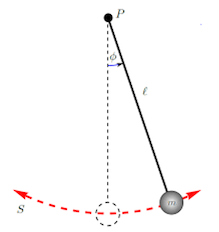

**Let us denote $\dot{\theta_t}:=\frac{d\theta}{dt}$ and
$\ddot{\theta}_t:=\frac{d^2\theta}{dt^2}$ as the first and second temporal
derivatives of $\theta$.** The dynamics of the pendulum is driven by the
following ODE on $\theta$:

\begin{equation} \ddot{\theta_t} + \omega_0^2~ sin\left(\theta_t\right) +
\alpha \dot{\theta}_t = 0 \end{equation}

where $\omega_0 = \sqrt{\frac{g}{\ell}}$ ($g$ is the gravitational constant, i.e. $9.8 ms^{-2}$), $\ell$ is the length of the rod,
and $\alpha = \frac{k}{ml^2}$ is the friction coefficient.

In the general case, the ODE does not have a closed-form
solution. Let us denote as $\mathbf{Y}_t=(\theta_t, \dot{\theta}_t)$ the 2d
state vector of the pendulum.

**我们用 $\dot{\theta_t}:=\frac{d\theta}{dt}$ 和 $\ddot{\theta}_t:=\frac{d^2\theta}{dt^2}$ 分别表示 $\theta$ 的一阶和二阶时间导数。**  
摆的动力学由以下关于 $\theta$ 的常微分方程（ODE）驱动：

$$
\ddot{\theta_t} + \omega_0^2~ \sin\left(\theta_t\right) + \alpha \dot{\theta}_t = 0
$$

其中 $\omega_0 = \sqrt{\frac{g}{\ell}}$（$g$ 为重力常数，即 $9.8 \, \text{m/s}^2$），$\ell$ 为摆杆的长度，$\alpha = \frac{k}{ml^2}$ 为摩擦系数。

在一般情况下，该 ODE 没有闭式解。我们用 $\mathbf{Y}_t=(\theta_t, \dot{\theta}_t)$ 表示摆的二维状态向量。


**<u>Question 1:</u> show that
 $\dot{\mathbf{Y}_t}=f\left({\mathbf{Y}_t}\right)$, *i.e* that the evolution
 of $\mathbf{Y}$ follows a first-order ODE. Give the expression of f.**

**<u>问题 1：</u>证明 $\dot{\mathbf{Y}_t}=f\left({\mathbf{Y}_t}\right)$，即 $\mathbf{Y}$ 的演化遵循一阶常微分方程。写出 $f$ 的表达式。**


From a given initial condition $\mathbf{Y}_0=(\theta_0, \dot{\theta}_0)$, we
can estimate the state vector $\mathbf{Y}_t$ at any time $t$:

\begin{equation} \mathbf{Y}_t = \mathbf{Y}_0 + \int_0^t \dot{\mathbf{Y}_t} ~dt
= \mathbf{Y}_0 + \int_0^t f\left(\mathbf{Y}_t\right) dt
\end{equation}

where $f\left( \mathbf{Y}_t \right)$ only depends on the current state
$\mathbf{Y}_t$ at time $t$. The integral can be approximated
with numerical schemes. The Euler method is simplest one (see figure below):
starting from $\mathbf{Y}_0$, we have $\mathbf{Y}_{t+1} = \mathbf{Y}_{t} +
f\left(\mathbf{Y}_t\right)$ $\forall t>1$. The has been extensive studies for
developing improved numerical solvers in the last centuries, e.g. different
orders of Runge-Kutta solvers.

从给定的初始条件 $\mathbf{Y}_0=(\theta_0, \dot{\theta}_0)$ 出发，我们可以估计任意时间 $t$ 的状态向量 $\mathbf{Y}_t$：

$$
\mathbf{Y}_t = \mathbf{Y}_0 + \int_0^t \dot{\mathbf{Y}_t} ~dt
= \mathbf{Y}_0 + \int_0^t f\left(\mathbf{Y}_t\right) dt
$$

其中，$f\left(\mathbf{Y}_t\right)$ 仅依赖于当前时间 $t$ 的状态 $\mathbf{Y}_t$。该积分可以通过数值方法进行近似。最简单的方法是欧拉法（见下图）：从 $\mathbf{Y}_0$ 开始，我们有 $\mathbf{Y}_{t+1} = \mathbf{Y}_{t} + f\left(\mathbf{Y}_t\right)$，对于所有 $t>1$ 均成立。在过去的几个世纪中，人们对改进数值求解器进行了广泛研究，例如不同阶数的 Runge-Kutta 求解器。

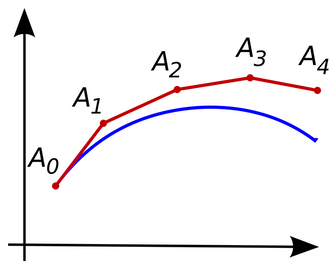


## Part I. Generating damped pendulum simulations
First, lets do some import

## 第 I 部分：生成阻尼摆的模拟

首先，让我们进行一些导入操作

In [1]:
import math, shelve
import os

from collections import OrderedDict

import torch
import numpy as np
from scipy.integrate import solve_ivp

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from torchdiffeq import odeint_adjoint, odeint

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20, 10]

ModuleNotFoundError: No module named 'torchdiffeq'

### I.a) DampledPendulum

**We will write a DampledPendulum Dataset, which simulates different pendulum trajectories from differents initial conditions. Fill the code in the code in the following DampledPendulum class. We use the following setting:** $\omega_0= \frac{\Pi}{3}$, $\alpha= 0.2$, time hoziron : 10, with $dt=0.5$

You have to fill the `__init__` and `_compute_trajectory` functions. For `_compute_trajectory`, the goal is to simulate a given trajectory from an initial condition:
- The function `_get_initial_condition` is provided
- To perform the simulation in `_compute_trajectory`, you need to:
    - Call the `_get_initial_condition`
    - Call the solver: we will use the solve_ivp method from from `scipy.integrate`, using the 'DOP853' method (Explicit Runge-Kutta method of order 8).
- Since the simulation is computationally demanding, the class below uses a cache to store each trajectory

### I.a) 阻尼摆 (Damped Pendulum)

**我们将编写一个阻尼摆数据集，用于模拟不同初始条件下的不同摆动轨迹。请在以下 `DampedPendulum` 类中填写代码。我们使用以下设置：**$\omega_0 = \frac{\Pi}{3}$，$\alpha = 0.2$，时间范围：10，步长 $dt = 0.5$。

你需要完成 `__init__` 和 `_compute_trajectory` 函数。对于 `_compute_trajectory`，目标是从初始条件模拟给定的轨迹：
- 提供了 `_get_initial_condition` 函数
- 在 `_compute_trajectory` 中进行模拟时，你需要：
    - 调用 `_get_initial_condition`
    - 调用求解器：我们将使用 `scipy.integrate` 中的 `solve_ivp` 方法，使用 'DOP853' 方法（显式 Runge-Kutta 8阶方法）。
- 由于模拟计算量大，下面的类使用缓存来存储每条轨迹。

In [2]:
class DampledPendulum(Dataset):
    def __init__(self, num_seq: int, time_horizon: int, dt: float):
        """Creates a new dataset of trajectories

        :param num_seq: Size of the dataset
        :param time_horizon: _description_
        :param dt: _description_
        """
        super().__init__()

        # À compléter...
        # assert False, 'Code non implémenté'
        self.omega0_square= (np.pi / 3) * (np.pi / 3) # FILL WITH YOUR CODE
        self.alpha = 0.2 # FILL WITH YOUR CODE
        self.len = num_seq # NUMBER OF SEQUENCES IN DATASET - FILL WITH YOUR CODE
        self.time_horizon = time_horizon # FILL WITH YOUR CODE

        # This caches the trajectories so we compute them once only
        self.data = [None] * num_seq

        self.t_eval = torch.arange(0, self.time_horizon, float(dt))

    def __getitem__(self, index: int):
        if self.data[index] is None:
            self.data[index] = torch.tensor(self._compute_trajectory(), dtype=torch.float32)
        return {"states": self.data[index], "t": self.t_eval}

    def __len__(self):
        return len(self.data)

    def _get_initial_condition(self):
        """Returns the vector of initial conditions"""
        y0 = np.random.randn(2) * 2.0 - 1
        r = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0**2).sum()) * r

        return y0

    def _get__state_derivative(self, t, x):  # coords = [q,p]
        # À compléter...
        # assert False, 'Code non implémenté'
        theta, theta_dot = x

        # Define the equations of motion
        dtheta_dt = theta_dot
        dtheta_dot_dt = -self.omega0_square * np.sin(theta) - self.alpha * theta_dot
        return [dtheta_dt, dtheta_dot_dt]

    def _compute_trajectory(self):
        # À compléter... #
        # assert False, 'Code non implémenté'

        # Get initial condition
        y0 = self._get_initial_condition()

        # Solve the ODE using solve_ivp from scipy.integrate
        sol = solve_ivp(
            self._get__state_derivative,
            [0, self.time_horizon],
            y0,
            t_eval=self.t_eval.numpy(),  # Use t_eval for time steps
            method='DOP853'
        )

        states = sol.y
        return states




### I.b) Train/test data generation

**We can now define train and test dataloader** (use 25 train/test sequences
with a batch size of 25). **Plot the resulting trajectories ($\theta$ and
optionally $\dot{\theta}$).**

### I.b) 训练/测试数据生成

**我们现在可以定义训练和测试数据加载器**（使用 25 个训练/测试序列，批量大小为 25）。**绘制生成的轨迹（$\theta$，并可选地绘制 $\dot{\theta}$）。**

In [3]:
# path = "./exp2/pendulum/pendulum"

num_seq = 25
time_horizon = 20
dt = 0.5
dataset_train = DampledPendulum(num_seq, time_horizon, dt)
dataset_test = DampledPendulum(num_seq, time_horizon, dt)


batch_size = 25

train_loader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=True,
)
test_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
)

In [4]:
# Show one item of the dataset

dataset_train[0]

{'states': tensor([[-0.9841, -1.7545, -2.2020, -2.3952, -2.3901, -2.2045, -1.8250, -1.2341,
          -0.4736,  0.3275,  1.0095,  1.3630,  1.4517,  1.2725,  0.8696,  0.3079,
          -0.2756, -0.7345, -0.9792, -0.9876, -0.7802, -0.4134,  0.0198,  0.4072,
           0.6564,  0.7265,  0.6199,  0.3751,  0.0598, -0.2400, -0.4508, -0.5306,
          -0.4734, -0.3052, -0.0766,  0.1497,  0.3165,  0.3881,  0.3563,  0.2384],
         [-1.8807, -1.1997, -0.6164, -0.1757,  0.1904,  0.5570,  0.9692,  1.3909,
           1.6398,  1.5077,  1.0371,  0.4620, -0.0984, -0.6006, -1.0029, -1.1943,
          -1.0832, -0.7214, -0.2521,  0.2118,  0.5991,  0.8368,  0.8568,  0.6601,
           0.3259, -0.0444, -0.3705, -0.5861, -0.6431, -0.5314, -0.2987, -0.0186,
           0.2385,  0.4168,  0.4762,  0.4094,  0.2457,  0.0379, -0.1593, -0.2994]]),
 't': tensor([ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
          4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,

<Figure size 2000x1000 with 0 Axes>

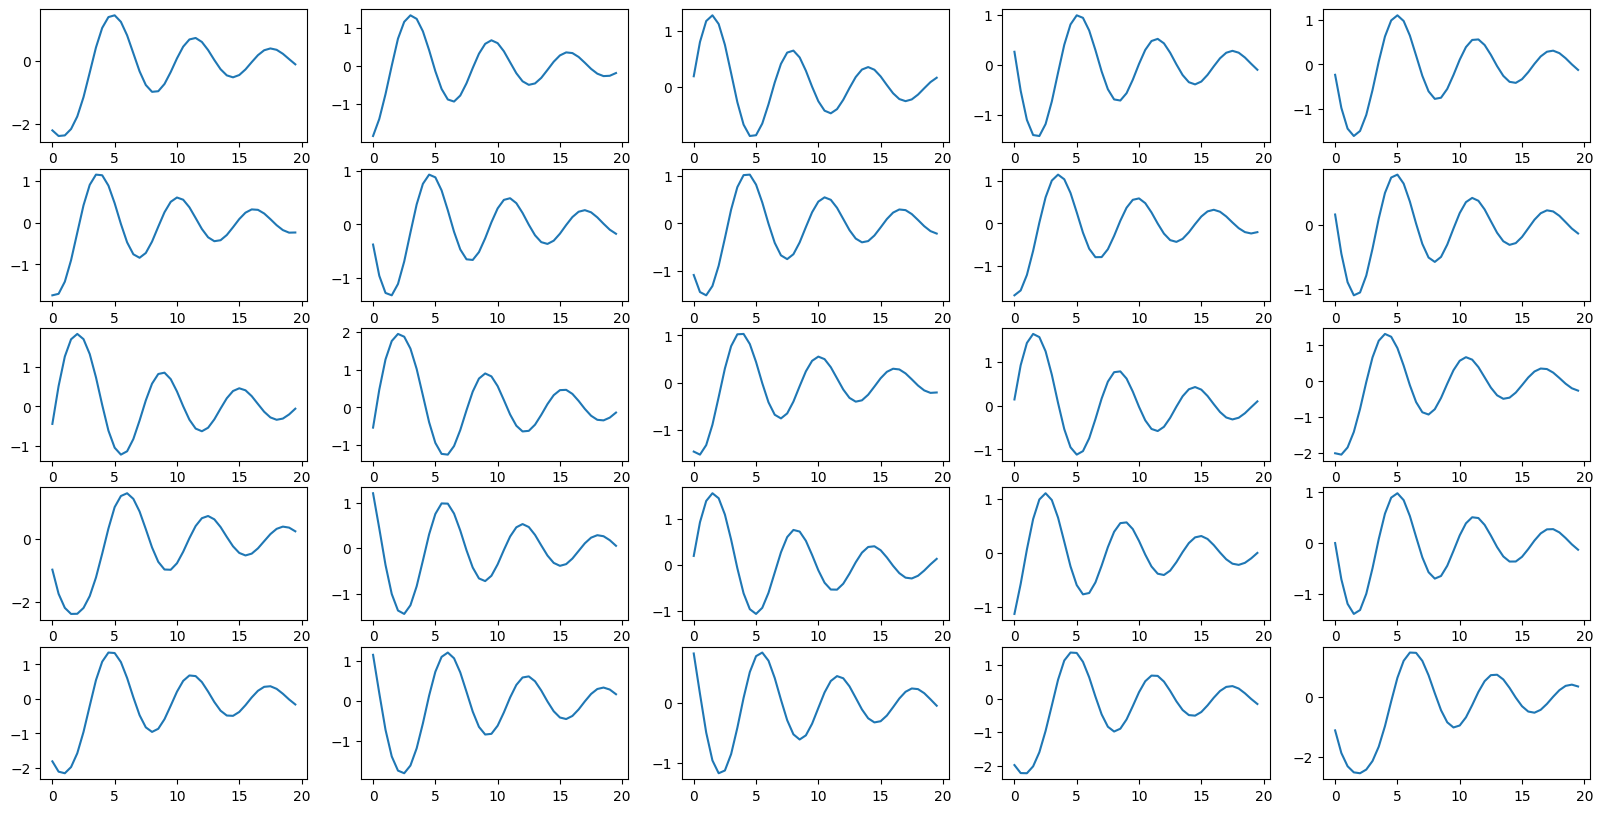

In [5]:
data = next(iter(train_loader))
draw_dottheta = False

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        # fig, (ax1, ax2) = plt.subplots(i+1, j+1)
        # plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
        axs[i, j].plot(data["t"][i * 5 + j], data["states"][i * 5 + j, 0, :])


if draw_dottheta == True:
    fig, axs = plt.subplots(5, 5)
    for i in range(5):
        for j in range(5):
            axs[i, j].plot(data["t"][i * 5 + j], data["states"][i * 5 + j, 1, :])

<Figure size 2000x1000 with 0 Axes>

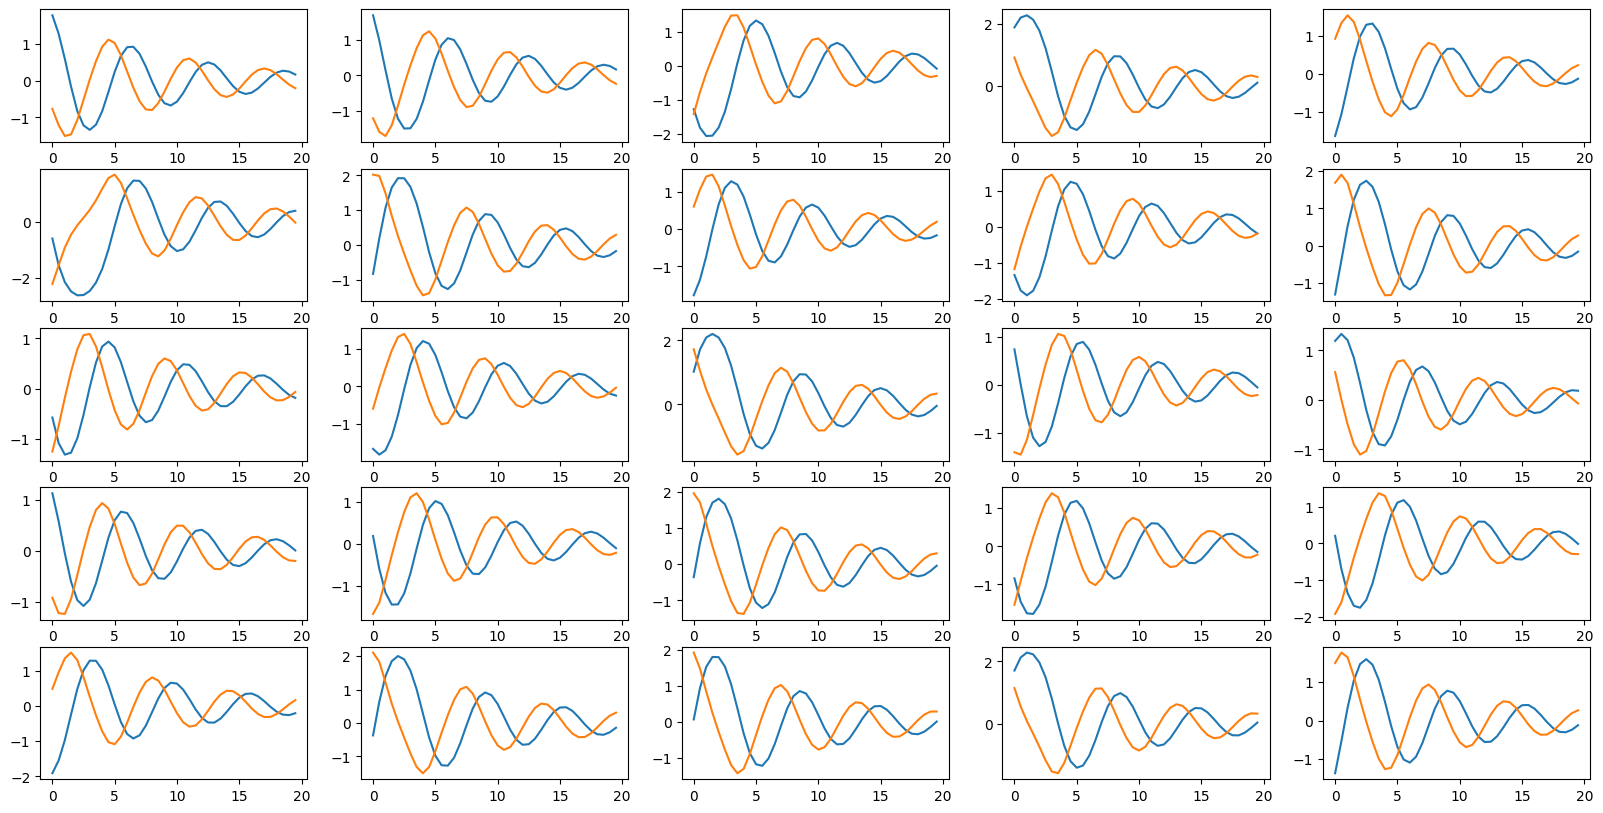

In [6]:
data_test = next(iter(test_loader))

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)
draw_dottheta = True

for i in range(5):
    for j in range(5):
        # fig, (ax1, ax2) = plt.subplots(i+1, j+1)
        # plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
        axs[i, j].plot(data_test["t"][i * 5 + j], data_test["states"][i * 5 + j, 0, :])

if draw_dottheta:
    for i in range(5):
        for j in range(5):
            # fig, (ax1, ax2) = plt.subplots(i+1, j+1)
            # plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
            axs[i, j].plot(
                data_test["t"][i * 5 + j], data_test["states"][i * 5 + j, 1, :]
            )


### Plot initial condition distribution

### 绘制初始条件分布

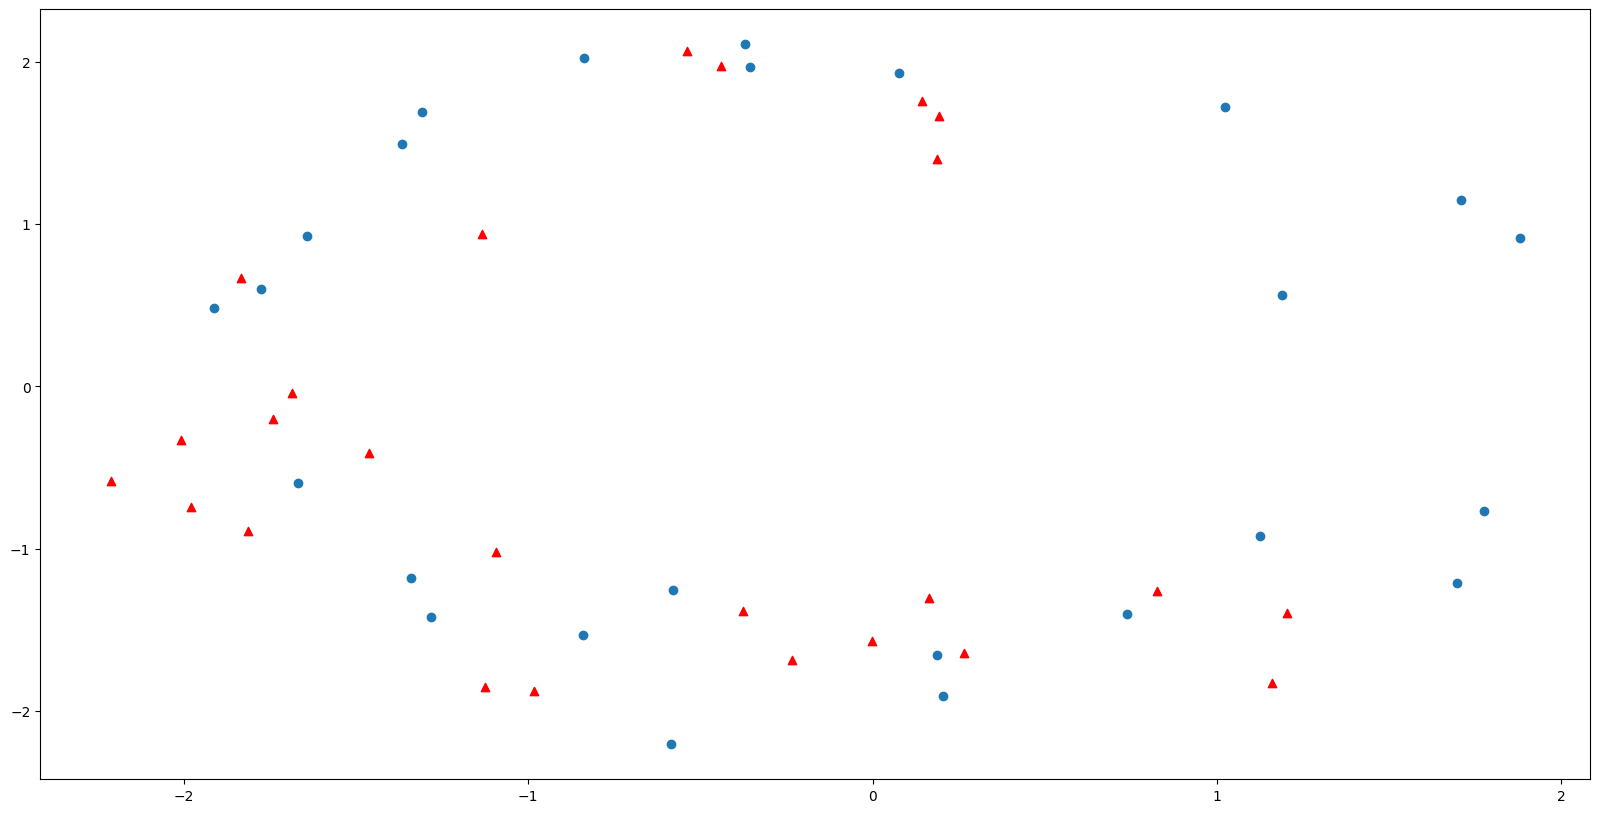

In [7]:
theta0_train = data["states"][:, 0, 0]
dtheta0_train = data["states"][:, 1, 0]

theta0_test = data_test["states"][:, 0, 0]
dtheta0_test = data_test["states"][:, 1, 0]

plt.figure()
plt.scatter(theta0_train, dtheta0_train, marker="^", c="r")
plt.scatter(theta0_test, dtheta0_test)


## 2) Predicting trajectories with Neural-ODE

The goal is to use the Neural-ODE method [1] to predict the future trajectory
from an initial condition. **More precisely, the idea is to define a
parametric model, *e.g.* an neural network, to predict the state's derivative
from the current state value:
$\dot{\mathbf{Y}_t}=f_{\theta}\left({\mathbf{Y}_t}\right)$, with $\theta$
being the neural net parameters. From an initial condition $\mathbf{Y}_0$ and
$f_{\theta}\left({\mathbf{Y}_t}\right)$, we can then use Equation below to
predict the full predicted trajectory $\hat{\mathbf{Y}}$. The goal is to
optimize $\theta$ parameters such that predicted trajectories are close to the
GT trajectories in the training set.**

\begin{equation} \hat{\mathbf{Y}_t}  = \mathbf{Y}_0 + \int_0^t
f_{\theta}\left(\mathbf{Y}_t\right) dt \end{equation}


**Let's fill the DerivativeEstimator class to predict the the state's
derivative.** We will use a simple MLP (2 hidden layers + ReLU) for prediction
since the state is a 2D vector.


## 2) 使用神经-ODE预测轨迹

目标是使用神经-ODE方法[1]从初始条件预测未来轨迹。**更精确地说，目标是定义一个参数化模型，例如神经网络，来预测从当前状态值得到的状态导数：$\dot{\mathbf{Y}_t}=f_{\theta}\left({\mathbf{Y}_t}\right)$，其中 $\theta$ 是神经网络的参数。从初始条件 $\mathbf{Y}_0$ 和 $f_{\theta}\left({\mathbf{Y}_t}\right)$，我们可以使用下面的方程来预测完整的预测轨迹 $\hat{\mathbf{Y}}$。目标是优化 $\theta$ 参数，使得预测的轨迹与训练集中的真实轨迹接近。**

$$
\hat{\mathbf{Y}_t} = \mathbf{Y}_0 + \int_0^t f_{\theta}\left(\mathbf{Y}_t\right) dt
$$

**让我们完成 `DerivativeEstimator` 类来预测状态的导数。** 由于状态是二维向量，我们将使用一个简单的多层感知器（2个隐藏层 + ReLU）来进行预测。

In [8]:
class DerivativeEstimator(nn.Module):
    def __init__(self, n_state: int, n_hidden: int):
        super().__init__()
        # À compléter...
        # assert False, 'Code non implémenté'

        self.fc1 = nn.Linear(n_state, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_state)

        self.relu = nn.ReLU()

    def forward(self, t, state):
        # À compléter...
        # assert False, 'Code non implémenté'

        # Forward
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        dx_dt = self.fc3(x)
        return dx_dt


**The forecaster will perform the prediction from a initial state $y_0$**. To
perform the numerical integration, we use the [`odeint` method from
torchdiffeq](https://github.com/rtqichen/torchdiffeq). We will use the generic
'rk4' solver to perform numerical integration. **Fill the following Forecaster
class with:**
- A constructor creating a reference to an DerivativeEstimator instance
- the forward method calls the `odeint` method to perform integration from an
  initial $y_0$ state. **N.B.**: the output dimensions after calling `odeint`
  will be `T x batch_size x n_c`, swap them to fit the requested Pytorch
  standard (`batch_size x n_c X T`)

**预测器将从初始状态 $y_0$ 开始进行预测**。为了执行数值积分，我们使用来自 [`torchdiffeq` 的 `odeint` 方法](https://github.com/rtqichen/torchdiffeq)。我们将使用通用的 'rk4' 求解器来执行数值积分。**请完成以下 `Forecaster` 类，包含：**
- 构造函数：创建对 `DerivativeEstimator` 实例的引用
- `forward` 方法：调用 `odeint` 方法，从初始状态 $y_0$ 开始进行积分。**注意：** 调用 `odeint` 后的输出维度将是 `T x batch_size x n_c`，需要调整它们的顺序以符合要求的 Pytorch 标准（`batch_size x n_c x T`）。

In [9]:
class Forecaster(nn.Module):
    def __init__(self, n_state, n_hidden, method="rk4"):
        super().__init__()

        # À compléter...
        # assert False, 'Code non implémenté'

        # 创建 DerivativeEstimator 实例，用于预测状态的导数
        self.derivate_estimator = DerivativeEstimator(n_state, n_hidden)
        self.method = method

    def forward(self, y0: torch.Tensor, t: torch.LongTensor):
        """Computes the $y_t$ prediction at times $t$
        given the initial state y0 of size (B x N_c).

        Returns a tensor of shape (B x N_c x T)
        """
        # À compléter...
        # assert False, 'Code non implémenté'

        # 使用 odeint 方法进行数值积分，返回的维度为 (T, B, N_c)
        solution = odeint(
            self.derivate_estimator, 
            y0, 
            t, 
            method=self.method
        )

        # 交换维度，使得输出维度为 (B, N_c, T)
        return solution.permute(1, 2, 0)


### Write the training loop!

For each batch:
- Get the first state of each training trajectory
- Perform prediction of the forecaster for each time step of the horizon
- We will use a simple MSE loss between the ground truth and predicted
  trajectories.
- Use an Adam optimizer (default paramters)
- Plot the train / test trajectories

### 编写训练循环！

对于每个批次：
- 获取每条训练轨迹的初始状态
- 对每个时间步长的预测进行预测
- 我们将使用简单的均方误差（MSE）损失来衡量真实轨迹和预测轨迹之间的差异。
- 使用 Adam 优化器（默认参数）
- 绘制训练集/测试集的轨迹

In [11]:
n_state = 2
n_hidden = 200
n_epochs = 1001
# tau_1 = 1e-3

forecaster_net = Forecaster(n_state, n_hidden)
optimizer = optim.Adam(forecaster_net.parameters())  # , lr=tau_1, betas=(0.9, 0.999))
traj_loss = nn.MSELoss()

for e in range(n_epochs):
    # À compléter...
    # assert False, 'Code non implémenté'
    
    forecaster_net.train()

    total_loss = 0
    
    for batch_idx, batch in enumerate(train_loader):
        y0 = batch['states'][:, :, 0]
        t = batch['t'][0, :]

        # 使用 Forecaster 进行预测
        predicted_trajectory = forecaster_net(y0, t)

        # 计算 MLP 损失
        loss = traj_loss(predicted_trajectory, batch['states'])

        # 更新模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 损失求和
        total_loss += loss.item()

    if (e + 1) % 100 == 0:
        print(f"Iteration [{(e+1)} / {n_epochs}]: loss = {total_loss / len(train_loader):.4f}")

Iteration [100 / 1001]: loss = 0.0326
Iteration [200 / 1001]: loss = 0.0055
Iteration [300 / 1001]: loss = 0.0021
Iteration [400 / 1001]: loss = 0.0010
Iteration [500 / 1001]: loss = 0.0007
Iteration [600 / 1001]: loss = 0.0003
Iteration [700 / 1001]: loss = 0.0002
Iteration [800 / 1001]: loss = 0.0001
Iteration [900 / 1001]: loss = 0.0001
Iteration [1000 / 1001]: loss = 0.0001


<Figure size 2000x1000 with 0 Axes>

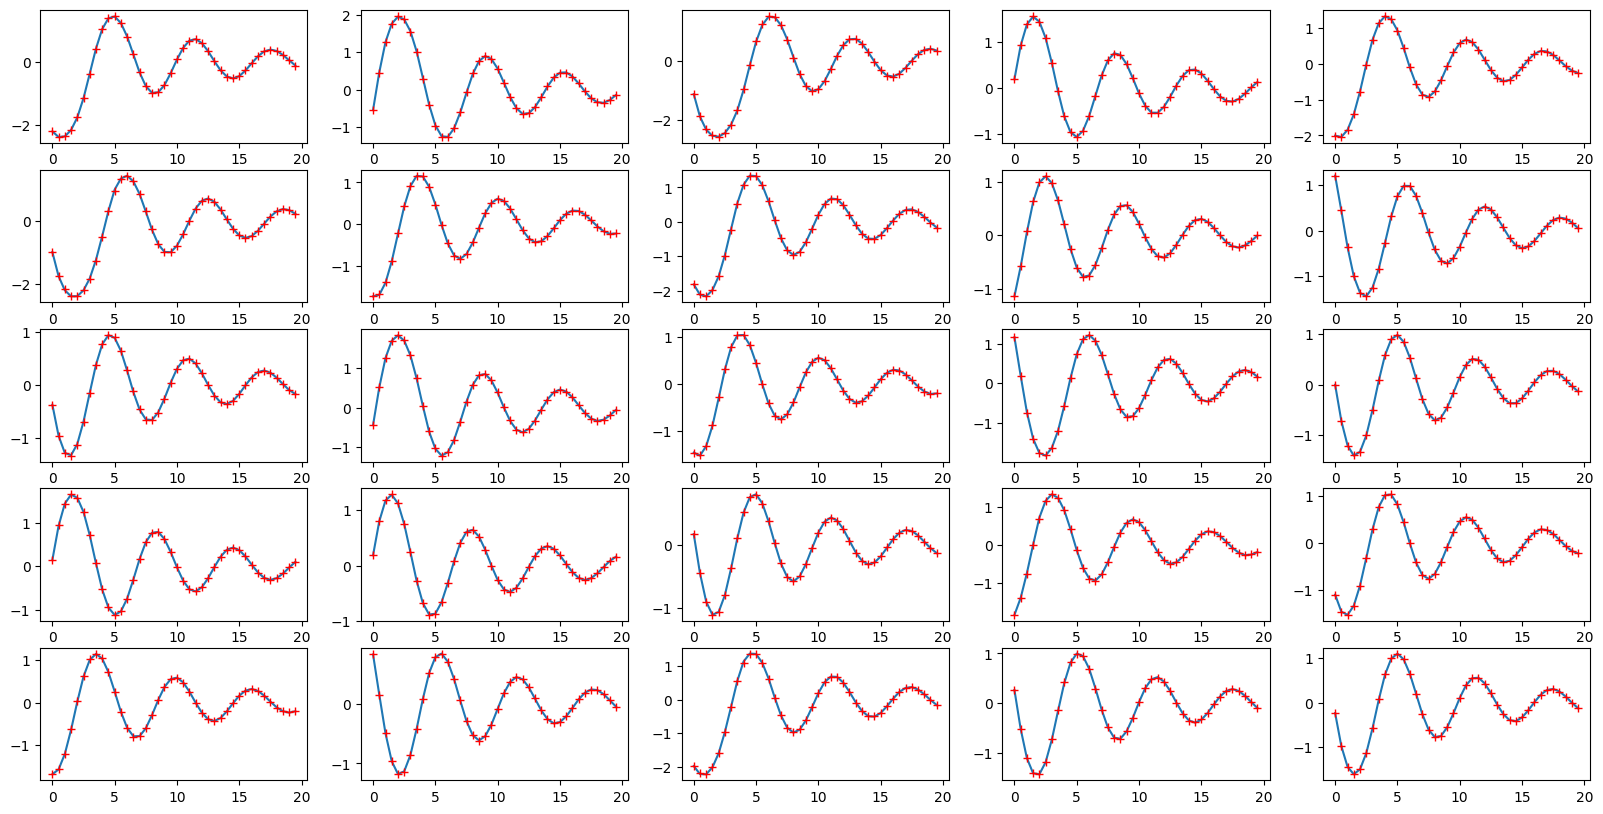

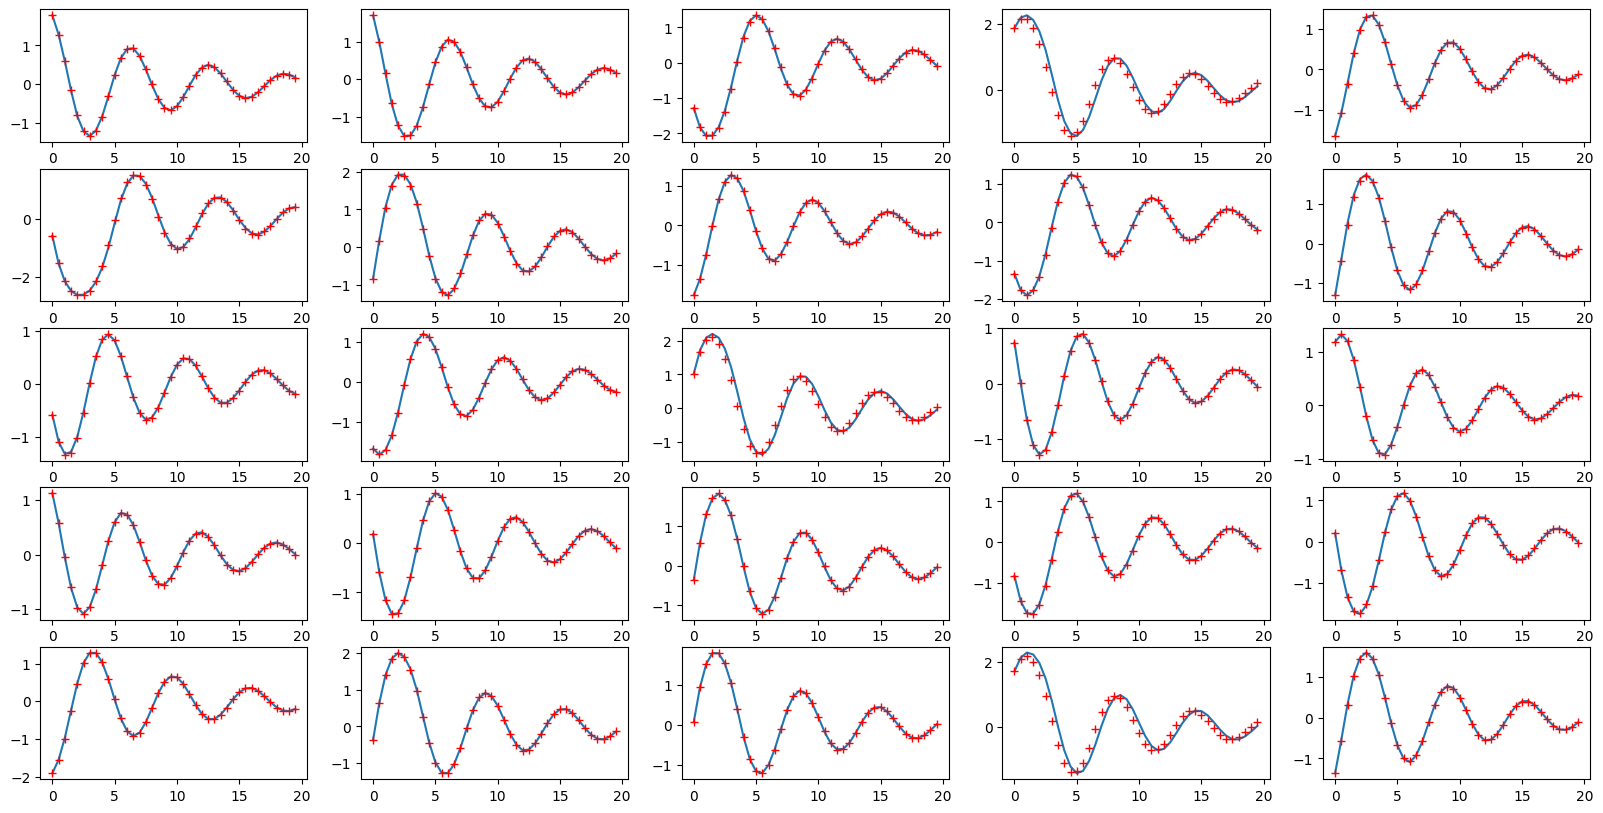

In [13]:
# The code below plots the predicted values

# pred contains
forecaster_net.eval()

with torch.no_grad():
    pred = []
    for batch in train_loader:
        y0 = batch['states'][:, :, 0]
        t = batch['t'][0, :]
        predictions = forecaster_net(y0, t)
        pred.append(predictions)

    pred = torch.cat(pred, dim=0)

with torch.no_grad():
    pred_test = []
    for batch_test in test_loader:
        y0 = batch_test['states'][:, :, 0]
        t = batch_test['t'][0, :]
        predictions = forecaster_net(y0, t)
        pred_test.append(predictions)

    pred_test = torch.cat(pred_test, dim=0)

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)
p = (pred.detach()).numpy()
ptest = pred_test.detach().numpy()

for i in range(5):
    for j in range(5):
        axs[i, j].plot(
            batch["t"][i * 5 + j],
            batch["states"][i * 5 + j, 0, :],
            batch["t"][i * 5 + j],
            p[i * 5 + j, 0, :],
            "r+",
        )

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].plot(
            batch_test["t"][i * 5 + j],
            batch_test["states"][i * 5 + j, 0, :],
            batch_test["t"][i * 5 + j],
            ptest[i * 5 + j, 0, :],
            "r+",
        )


# Bonus: see [this paper](https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf) [1]
Experiment Neural ODE for other applications:
- **Replacing residual networks with ODEs for supervised learning** (see section 3 in paper), using the adjoint method.
- **Application for irregularly-sampled time series** (see section 5 in the paper).


# Bonus：请参见 [这篇论文](https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf) [1]  
尝试将神经-ODE应用于其他领域：
- **用ODE替代残差网络进行监督学习**（请参见论文第3节），使用伴随法（adjoint method）。
- **应用于不规则采样的时间序列**（请参见论文第5节）。

[1] **Neural Ordinary Differential Equations.**
Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David K. Duvenaud.
NeurIPS 2018.

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->